In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [2]:
# set seed, sehingga kita dapat hasil yag sama setelah rerunning beberapa kali
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [3]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data dari Yahoo Finance database, apatah untuk scaling, shuffling, normalizing dan splitting.
    Params:
        ticker (str/pd.DataFrame): nama kode Saham yang ingin diambil, examples include BBNI.JK, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) digunakan untuk prediksi, default = 50
        scale (bool): apakah untuk merubah skala harga dari 0 ke 1, default = True
        shuffle (bool): apakah mau mengacak dataset (baik training & testing), default = True
        lookup_step (int): langkah untuk melihat ke depan dalam prediksi, defaultnya 1 (misal 1 hari besok)
        split_by_date (bool): apakah dataset mau dipisah antara training/testing by date, silahkan set disini 
            ke False maka datasets akan displit secara random
        test_size (float): rasio uji data, default nilainya 0.2 (20% testing data)
        feature_columns (list): List features yang digunakan dalam model, defaultnya apasaja yang ada dari yahoo_fin
    """
    # Cek apakah Kode Tiker sudah diambil dari yahoo finance
    if isinstance(ticker, str):
        # load dari yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # Sudah loaded, langsung kita gunakan
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    # disini akan berisi semua yang ingin tampilkan dari fungsi-fungsi disini
    result = {}
    
    # kita juga tampilkan original dataframe itu sendiri
    result['df'] = df.copy()
    
    # pastikan passed feature_columns ada dalam dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' gak ada dalam dataframe."
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        
        # scale data (harga) dari 0 ke 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        
        # tambahkan contoh MinMaxScaler dalam tampilan
        result["column_scaler"] = column_scaler
    
    # tambah column (label) dari `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    
    # last `lookup_step` columns yang kosong atau NaN in dalam kolom future
    # Rekam dulu sebelum NaNs dibuang
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # Buang data NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    
    # Ambil last sequence dengan menambah last `n_step` sequence dengan `lookup_step` sequence
    # Misalnya, jika n_steps=50 dan lookup_step=10, maka last_sequence seharusnya 60 (dimana 50+10) untuk panjangnya
    # Data last_sequence akan digunakan untuk predict harga saham kedepan yang tidak ada dalam datasets
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    
    # Tambahkan Result-nya
    result['last_sequence'] = last_sequence
    
    # Buat X's dan y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    
    # convert ke numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split dataset jadi training & testing berdasarkan tanggal (bukan splitting secara random)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle datasets untuk data training (jika shuffle parameter adalah set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split dataset secara random
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # list data test berdasarkan tanggal
    dates = result["X_test"][:, -1, -1]
    
    # tampilkan test features dari original dataframe
    result["test_df"] = result["df"].loc[dates]
    
    # buang tanggal yang sama pada testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    
    # buang tanggal dari training/testing sets & convert ke float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [4]:
#MLP
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # tambah dropout pada setiap layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [5]:
import os
import time
from tensorflow.keras.layers import LSTM

# Ukuran Window untui panjang sequensinya
N_STEPS = 50

# Lookup step, 1 adalah sehari yang akan datang
LOOKUP_STEP = 15

# Apakah mau scale feature columns & output harganya
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# Apakah mau shuffle dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

# Apakah mau pisahin training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

# Ukuran test ratio, 0.2 is 20%
TEST_SIZE = 0.2

# features yang akan digunakan
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

# tanggal sekarang
date_now = time.strftime("%Y-%m-%d")

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = LSTM

# 256 LSTM neurons
UNITS = 256

# 40% dropout
DROPOUT = 0.4

# Apakah mau menggunakan metode bidirectional RNNs
BIDIRECTIONAL = False

### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 18

# Kode Harga Saham dari Yahoo Fiance
ticker = "DEAL.JK"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model disimpan, nama dibuat seunik mungkin berdasarkan parameternya
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [6]:
# Buat folders jika belom ada
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [7]:
# load data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# Simpan dataframe
data["df"].to_csv(ticker_data_filename)

# Buat modelnya
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# Tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# train model dan simpan bobotnya dimanapun kita lihat 
# Sebuah model optimal baru dalam ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/18
8/8 [==============================] - 18s 2s/step - loss: 0.0266 - mean_absolute_error: 0.1423 - val_loss: 0.0121 - val_mean_absolute_error: 0.0895

Epoch 00001: val_loss improved from inf to 0.01205, saving model to results\2021-06-09_DEAL.JK-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 2/18
8/8 [==============================] - 7s 899ms/step - loss: 0.0121 - mean_absolute_error: 0.0881 - val_loss: 0.0105 - val_mean_absolute_error: 0.0865

Epoch 00002: val_loss improved from 0.01205 to 0.01053, saving model to results\2021-06-09_DEAL.JK-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 3/18
8/8 [==============================] - 8s 960ms/step - loss: 0.0116 - mean_absolute_error: 0.0897 - val_loss: 0.0089 - val_mean_absolute_error: 0.0785

Epoch 00003: val_loss improved from 0.01053 to 0.00890, saving model to results\2021-06-09_DEAL.JK-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h

#Gunakan Prompt atau Power Shell dan ketikan perintah ini:
tensorboard --logdir="logs"

#Masuk ke Web
http://localhost:6006/

In [20]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    Fungsi ini akan menggambarkan harga penutupan bersama dengan harga yang diprediksi kedepan
    dengan masing-masing warna biru dan merah
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Hari")
    plt.ylabel("Harga")
    plt.legend(["Harga Saham", "Harga Prediksi"])
    plt.show()

In [9]:
def get_final_df(model, data):
    """
    Fungsi ini mengambil dict 'model' dan 'data' untuk 
    membangun kerangka akhir dataframe dimana sudah mencakup fitur-fitur di sepanjang 
    harga aktual dan harga prediksi dari kumpulan data pengujian
    """
    # jika harga prediksi lebih tinggi dari harga sekarang, 
    # maka hitung harga kedepan dikurangi dengan harga sekarang guna mendapatkan nilai untung
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    
    # jika harga prediksi lebih renda dari harga sekarang,
    # maka kurangi harga yang akan datang dengan hargasebenarnya pada harga saat ini
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # Tampilkan prediksi dan dapatkan harganya
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    
    # Tambahkan harga prediksi kedepan dalam dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    
    # Tambahkan harga aktual kedepan dalam dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    
    # sort dataframe berdasarkan tanggal
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    # Tambah kolom keuntungan beli
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # Tambah kolom keuntungan jual
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [10]:
def predict(model, data):
    # Tarik last sequence dari data
    last_sequence = data["last_sequence"][-N_STEPS:]
    
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # Penskalaan prediksi (dari 0 ke 1)
    prediction = model.predict(last_sequence)
   
    # Harga Prediksi (setelah skala diinvert)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [11]:
try:
    # Handling Error saja...
except HTMLParseError:
    pass


# Muat optimal model weights dari results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

IndentationError: expected an indented block (<ipython-input-11-2bf77d424e0f>, line 3)

In [12]:
# evaluasi  model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

# Hitung mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [13]:
# final dataframe dari data pengujian
final_df = get_final_df(model, data)

In [14]:
# prediksi harga kedepan
future_price = predict(model, data)

In [15]:
# kita hitung accurasinya dengan menghitung jumlah positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# perhitungan total beli & profit penjualan
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

# total profit dengan menambah penualan dan pembelian secara bersama
total_profit = total_buy_profit + total_sell_profit

# pembagian total profit dengan jumlah testing samples (jumlah penjualan)
profit_per_trade = total_profit / len(final_df)

In [16]:
# printing metrics
print(f"Harga yang akan datang setelah {LOOKUP_STEP} hari adalah sebesar {future_price:.2f} Rupiah")
print(f"{LOSS} rugi:", loss)
print("Mean Absolute Error MAE:", mean_absolute_error)
print("Accuracy Score:", accuracy_score)
print("Total keuntungan pembelian:", total_buy_profit)
print("Total keuntungan penjualan:", total_sell_profit)
print("Total profit keuntungan:", total_profit)
print("Profit per penjualan:", profit_per_trade)

Harga yang akan datang setelah 15 hari adalah sebesar 92.25 Rupiah
huber_loss rugi: 0.00628513703122735
Mean Absolute Error MAE: 213.08098025619984
Accuracy Score: 0.35344827586206895
Total keuntungan pembelian: 1256.091682434082
Total keuntungan penjualan: -2193.725410461426
Total profit keuntungan: -937.6337280273438
Profit per penjualan: -8.083049379546067


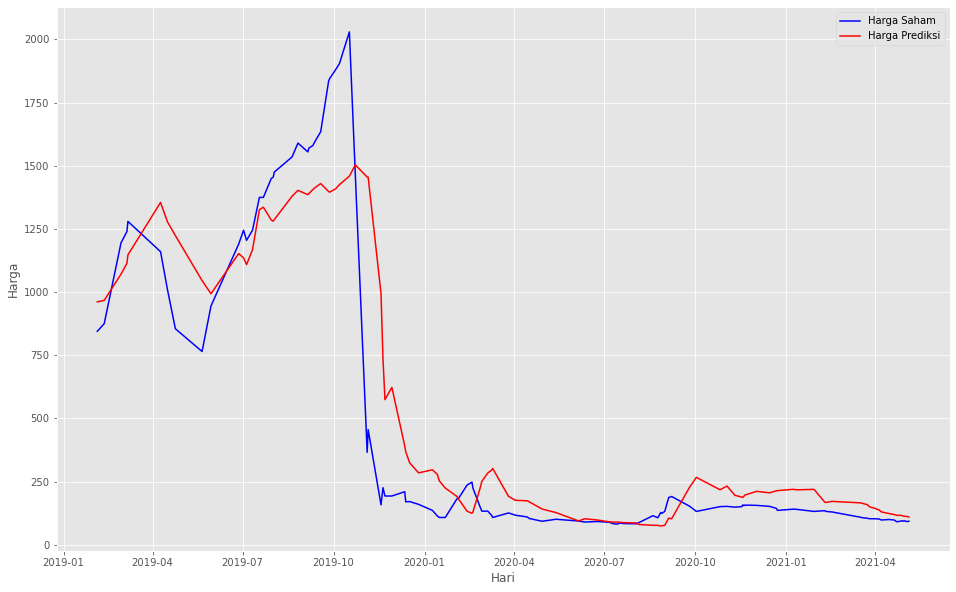

In [21]:
# plot grafik harga aktual dan harga prediksi
plt.figure(figsize=(16, 10)) 
plt.style.use('ggplot')
plot_graph(final_df)

In [19]:
print(final_df.tail(10))
# Simpan final dataframe ke folder hasil dalam format csv
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

             open   high    low  close  adjclose      volume   ticker  \
2021-04-15  105.0  108.0  104.0  105.0     105.0   2601900.0  DEAL.JK   
2021-04-20  103.0  104.0  100.0  103.0     103.0   2611400.0  DEAL.JK   
2021-04-22  102.0  104.0  101.0  103.0     103.0   1767600.0  DEAL.JK   
2021-04-23  102.0  103.0  101.0  102.0     102.0   2789700.0  DEAL.JK   
2021-04-27  103.0  103.0   95.0   96.0      96.0  14110100.0  DEAL.JK   
2021-04-28   97.0  100.0   93.0   98.0      98.0  11654700.0  DEAL.JK   
2021-04-29   98.0   98.0   95.0   97.0      97.0   3517600.0  DEAL.JK   
2021-04-30   97.0  104.0   95.0  103.0     103.0  22287500.0  DEAL.JK   
2021-05-03  104.0  104.0   99.0  100.0     100.0   6709000.0  DEAL.JK   
2021-05-05  105.0  105.0   98.0  100.0     100.0   2596200.0  DEAL.JK   

            adjclose_15  true_adjclose_15  buy_profit  sell_profit  
2021-04-15   123.557793             100.0         0.0   -18.557793  
2021-04-20   119.799469              98.0         0.0   -1